In [79]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [80]:
import torch
import transformers
torch.__version__, transformers.__version__

('2.6.0', '4.51.2')

In [81]:
torch.backends.mps.is_available()

True

In [82]:
df = pd.read_csv('Sentences_66Agree.csv')
df['label'] = df['label'].map({"positive": 0, "neutral": 1, "negative": 2})
df = df.dropna(subset=['sentence', 'label'])

LABEL_MAP = {"positive": 0, "neutral": 1, "negative": 2}

In [83]:
    # 数据分割（保持原有比例）
df_train, df_test = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=42)


In [84]:
#模型和分词器
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
# 定义分词函数
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

In [86]:
# 数据集处理
dataset_train = Dataset.from_pandas(df_train).map(tokenize_function, batched=True)
dataset_val = Dataset.from_pandas(df_val).map(tokenize_function, batched=True)
dataset_test = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)

# 设置张量格式
columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label']
dataset_train.set_format(type='torch', columns=columns)
dataset_val.set_format(type='torch', columns=columns)
dataset_test.set_format(type='torch', columns=columns)

Map: 100%|██████████| 422/422 [00:00<00:00, 2045.13 examples/s]


In [ ]:
args = TrainingArguments(
        logging_steps=10,
        use_mps_device=True,
        output_dir = 'temp/',
        eval_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=args,                  # training arguments, defined above
    train_dataset=dataset_train,         # training dataset
    eval_dataset=dataset_val,            # evaluation dataset
    compute_metrics=compute_metrics)

trainer.train()   

/opt/anaconda3/envs/pidan_ovo/lib/python3.12/site-packages/transformers/training_args.py:2243: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.31410807371139526,
 'test_accuracy': 0.8767772511848341,
 'test_runtime': 6.0265,
 'test_samples_per_second': 70.024,
 'test_steps_per_second': 4.48}

In [ ]:
# 预测测试集并输出指标
test_results = trainer.predict(dataset_test)
print("测试集指标:", test_results.metrics)


测试集指标: {'test_loss': 0.31410807371139526, 'test_accuracy': 0.8767772511848341, 'test_runtime': 5.0602, 'test_samples_per_second': 83.396, 'test_steps_per_second': 5.336}


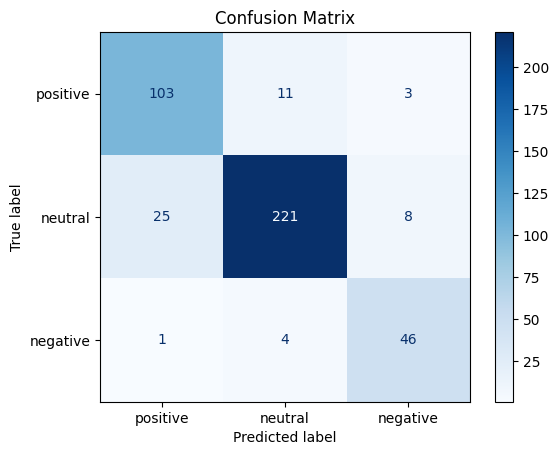

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 获取预测结果
predictions = np.argmax(test_results.predictions, axis=1)
labels = test_results.label_ids

# 生成混淆矩阵
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["positive", "neutral", "negative"]
)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# 加载模型并移至 MPS
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels=3)
model.to('mps')  # 关键步骤

# 数据预处理函数（强制分配到 MPS）
def tokenize_function(examples):
    tokenized = tokenizer(
        examples['sentence'],
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="pt"
    )
    return {k: v.to('mps') for k, v in tokenized.items()}  # 数据移至 MPS

# 处理测试集
dataset_test = dataset_test.map(tokenize_function, batched=True)

# 随机抽取样本推理
sample_idx = random.randint(0, len(dataset_test)-1)
sample = dataset_test[sample_idx]

# 确保数据在 MPS（如果预处理未正确分配）
input_ids = sample['input_ids'].unsqueeze(0).to('mps')
attention_mask = sample['attention_mask'].unsqueeze(0).to('mps')

# 推理
with torch.no_grad():
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
predicted_label = torch.argmax(logits).item()

# 输出结果
true_label = sample['label'].item()
label_map = {0: "positive", 1: "neutral", 2: "negative"}
print("原文:", df_test.iloc[sample_idx]['sentence'])
print("真实标签:", label_map[true_label])
print("预测标签:", label_map[predicted_label])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 422/422 [00:00<00:00, 3333.65 examples/s]


原文: "Following the payment made in April , the company has a total of EUR 23.0 million in loans from financial institutions ."
真实标签: neutral
预测标签: neutral


In [ ]:
from sklearn.metrics import classification_report

# 生成分类报告
report = classification_report(
    labels, 
    predictions, 
    target_names=["positive", "neutral", "negative"]
)
print("分类报告:\n", report)

分类报告:
               precision    recall  f1-score   support

    positive       0.86      0.86      0.86       117
     neutral       0.94      0.91      0.92       254
    negative       0.84      0.92      0.88        51

    accuracy                           0.90       422
   macro avg       0.88      0.90      0.89       422
weighted avg       0.90      0.90      0.90       422



In [ ]:
# 获取所有预测错误的样本索引
errors = np.where(predictions != labels)[0]

# 查看前 5 条错误样本
for i in errors[:5]:
    print("原文:", df_test.iloc[i]['sentence'])
    print("真实标签:", label_map[labels[i]])
    print("预测标签:", label_map[predictions[i]])
    print("---")

原文: "Finnish food industry companies HK Ruokatalo and Atria will form a joint venture company called L+ñnsi-Kalkkuna to produce turkey meat ."
真实标签: positive
预测标签: neutral
---
原文: "Industry Investment is very interested in Glaston 's solar energy projects ."
真实标签: positive
预测标签: neutral
---
原文: "Our solutions are fully Arabized , and our message is that we want to become the IT partner of choice for businesses in the Near-East region ."
真实标签: neutral
预测标签: positive
---
原文: "As a result of the cancellation , the maximum increase of Citycon 's share capital on the basis of the convertible bonds decreased from EUR 23,383,927.80 to EUR 22,901,784.75 ."
真实标签: neutral
预测标签: negative
---
原文: "However , this increases signaling traffic which wastes network resources and allows fewer smartphones to connect ."
真实标签: negative
预测标签: positive
---
